In [1]:
!cp ../input/blockchainetl/*.png .

In [2]:
'''
以太坊数据分析
李丽丽
2023-03-28
'''
import datetime
import time
import requests
import json
import os
import glob
import warnings
import pandas as pd

from IPython.display import IFrame
from IPython.display import display, HTML

from kaggle_secrets import UserSecretsClient

warnings.filterwarnings('ignore')

timezone = datetime.timezone.utc # 协调世界时（英语：Coordinated Universal Time，简称UTC）

user_secrets = UserSecretsClient()
#provider_uri = "https://nd-124-456-404.p2pify.com/b12f349a0c5ed60e78f9460bfc6bfddd'"
provider_uri = user_secrets.get_secret("CHAINSTACK_EXECUTION_HTTPS")

def now():
    return datetime.datetime.now(tz=timezone)

today_date = now().date()
yesterday_date = today_date - datetime.timedelta(1)
today, yesterday = str(today_date), str(yesterday_date)
str(now())

'2023-03-28 10:33:59.247492+00:00'

# 以太坊数据分析 - Ethereum ETL

李丽丽  
2023-03-28

目录

0. 前言
    * 0.1 Blockchain ETL
        * 支持导出数据
        * 计划中
1. 概览
    * 1.1 导出数据
        * 表结构
    * 1.2 应用
2. 命令
3. 导出区块链数据
    * 3.1 导出最新的100个区块所有区块链数据
        * 最新的一百个区块区间以及当前时间戳
        * 导出数据并统计时间
        * 查看output目录
        * 统计csv行数
        * 查看每个csv前2行
        * 读取csv，并查看前2行
        * 数据清洗
        * 数据分析
    * 3.2 2小时内导出方案
4. 使用Google BigQuery查询区块数据（SQL）
    * 4.1 表探索
        * 区块
        * 交易
        * ERC20（代币） / ERC721（NFT）
        * 通证交易
        * 收据
        * 日志
        * 合约
        * 内部交易
    * 4.2 数据洞察
        * 余额最多的账户
        * 以太币每日总供应量
        * 两笔内部交易间最短路径
        * 最近90天挖矿最多的几个账户
        * 不同区块链交易吞吐量对比
5. 源码解读
    * 5.1 下载源码
    * 5.2 JSON RPC 请求
    * 5.3 jobs
    * 5.4 common
    * 5.5 blocks & transactions
    * 5.6 token transfers
    * 5.7 receipts & logs
    * 5.8 contracts
    * 5.9 tokens
    * 5.10 traces

## 0. 前言
### 0.1 Blockchain ETL

https://github.com/blockchain-etl  促进区块链数据分析

#### 支持导出数据

https://github.com/blockchain-etl/public-datasets

In [3]:
pd.set_option('display.max_colwidth', None)
datasets = pd.read_html('https://github.com/blockchain-etl/public-datasets')
datasets[0]

,Network,BigQuery,Lag,PubSub,Node repo(s),Indexer repo(s)
0,Band,🔍 (Examples),0,💧,band-kubernetes,band-etl
1,Bitcoin,🔍 (Examples),3,💧,docker-bitcoind,"bitcoin-etl, bitcoin-etl-airflow, bitcoin-etl-airflow-neo4j, bitcoin-etl-streaming"
2,Bitcoin Cash,🔍 (Examples),6,💧,docker-bitcoin-cashd,see Bitcoin
3,Celo,🔍,10,💧,?,celo-etl
4,Dash,🔍 (Examples),24,💧,docker-dashd,see Bitcoin
5,Dogecoin,🔍 (Examples),60,💧,docker-dogecoind,see Bitcoin
6,Ethereum,🔍 (Examples),18,💧,?,"ethereum-etl, ethereum-etl-airflow, ethereum-etl-neo4j, ethereum-etl-postgres"
7,Ethereum 2,🔍,?,❌,?,"ethereum2-etl, ethereum2-etl-airflow"
8,Ethereum Classic,🔍 (Examples),?,❌,see Ethereum,see Ethereum
9,Fantom,🔍,?,💧,?,?


备注：[Ethereum 2.0 ETL](https://github.com/blockchain-etl/ethereum2-etl)可以导出信标节点beacon数据

#### 计划中

In [4]:
datasets[1]

,Network,BigQuery,Lag,PubSub,Node repo(s),Indexer repo(s),Notes
0,Algorand,⏳,?,⏳,?,?,Needs help
1,Aptos,⏳,?,⏳,?,?,Needs help
2,Arbitrum,⏳,?,⏳,?,?,Needs help
3,Avalanche,⏳,?,⏳,?,?,Needs help
4,BNB Chain,⏳,?,⏳,?,?,Needs help
5,Cronos,⏳,?,⏳,?,?,Needs help
6,Eos,❌,?,❌,?,"eos-etl, eos-etl-airflow",Needs help
7,Icon,❌,?,❌,?,"icon-etl, icon-etl-airflow",Needs help
8,Klaytn,👷,?,👷,?,klaytn-etl,In progress
9,Optimism,⏳,?,⏳,?,?,Needs help


## 1. 概览

Ethereum ETL可以将区块链数据转化成csv或者关系型数据库数据，在github上有2.5k星星，是最受欢迎的开源以太坊数据ETL工具

<img src="blockchain_etl_5.png" width="600" height="300">

* 代码：https://github.com/blockchain-etl/ethereum-etl 
* 帮助文档：https://ethereum-etl.readthedocs.io/en/latest/ 

### 1.1 导出数据

* 区块 (blocks)
* 交易 (transactions)
* 代币 / NFT (ERC20 / ERC721 tokens)
* 通证交易 (token transfer)
* 收据 (receipts)
* 日志 (logs)
* 合约 (contracts)
* 内部交易 (internal transactions)

#### 表结构

https://github.com/blockchain-etl/ethereum-etl-airflow/tree/master/dags/resources/stages/raw/schemas

In [5]:
!rm -rf ethereum-etl-airflow
!git clone https://github.com/blockchain-etl/ethereum-etl-airflow

Cloning into 'ethereum-etl-airflow'...
remote: Enumerating objects: 17102, done.
remote: Counting objects: 100% (694/694), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 17102 (delta 501), reused 607 (delta 447), pack-reused 16408
Receiving objects: 100% (17102/17102), 2.35 MiB | 5.79 MiB/s, done.
Resolving deltas: 100% (12925/12925), done.


In [6]:
pathname = 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/*'
json_files = glob.glob(pathname)
json_files

['ethereum-etl-airflow/dags/resources/stages/raw/schemas/blocks.json',
 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/traces.json',
 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/transactions.json',
 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/contracts.json',
 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/logs.json',
 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/token_transfers.json',
 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/receipts.json',
 'ethereum-etl-airflow/dags/resources/stages/raw/schemas/tokens.json']

In [7]:
pd.set_option('display.max_colwidth', None)

schema = dict()
for json_file in json_files:
    table = os.path.basename(json_file).split('.')[0]
    table_schema = pd.read_json(json_file)
    schema[table] = table_schema
    
tables = ['blocks', 'transactions', 'token_transfers', 'receipts', 'logs', 'contracts', 'tokens', 'traces']
for table in tables:
    print(table)
    display(schema[table])
    print()

blocks


,name,type,mode,description
0,number,INT64,REQUIRED,The block number
1,hash,STRING,REQUIRED,Hash of the block
2,parent_hash,STRING,NaN,Hash of the parent block
3,nonce,STRING,REQUIRED,Hash of the generated proof-of-work
4,sha3_uncles,STRING,NaN,SHA3 of the uncles data in the block
5,logs_bloom,STRING,NaN,The bloom filter for the logs of the block
6,transactions_root,STRING,NaN,The root of the transaction trie of the block
7,state_root,STRING,NaN,The root of the final state trie of the block
8,receipts_root,STRING,NaN,The root of the receipts trie of the block
9,miner,STRING,NaN,The address of the beneficiary to whom the mining rewards were given



transactions


,name,type,mode,description
0,hash,STRING,REQUIRED,Hash of the transaction
1,nonce,INT64,REQUIRED,The number of transactions made by the sender prior to this one
2,block_hash,STRING,REQUIRED,Hash of the block where this transaction was in
3,block_number,INT64,REQUIRED,Block number where this transaction was in
4,transaction_index,INT64,REQUIRED,Integer of the transactions index position in the block
5,from_address,STRING,REQUIRED,Address of the sender
6,to_address,STRING,NaN,Address of the receiver. null when its a contract creation transaction
7,value,NUMERIC,NaN,Value transferred in Wei
8,gas,INT64,NaN,Gas provided by the sender
9,gas_price,INT64,NaN,Gas price provided by the sender in Wei



token_transfers


,name,type,mode,description
0,token_address,STRING,REQUIRED,ERC20 token address
1,from_address,STRING,NaN,Address of the sender
2,to_address,STRING,NaN,Address of the receiver
3,value,STRING,NaN,Amount of tokens transferred (ERC20) / id of the token transferred (ERC721). Use safe_cast for casting to NUMERIC or FLOAT64
4,transaction_hash,STRING,REQUIRED,Transaction hash
5,log_index,INT64,REQUIRED,Log index in the transaction receipt
6,block_number,INT64,NaN,The block number



receipts


,name,type,mode,description
0,transaction_hash,STRING,REQUIRED,Hash of the transaction
1,transaction_index,INT64,REQUIRED,Integer of the transactions index position in the block
2,block_hash,STRING,NaN,Hash of the block where this transaction was in
3,block_number,INT64,NaN,Block number where this transaction was in
4,cumulative_gas_used,INT64,NaN,The total amount of gas used when this transaction was executed in the block
5,gas_used,INT64,NaN,The amount of gas used by this specific transaction alone
6,contract_address,STRING,NaN,"The contract address created, if the transaction was a contract creation, otherwise null"
7,root,STRING,NaN,32 bytes of post-transaction stateroot (pre Byzantium)
8,status,INT64,NaN,Either 1 (success) or 0 (failure) (post Byzantium)
9,effective_gas_price,INT64,NaN,The actual value per gas deducted from the senders account. Replacement of gas_price after EIP-1559



logs


,name,type,mode,description
0,log_index,INT64,REQUIRED,Integer of the log index position in the block
1,transaction_hash,STRING,REQUIRED,Hash of the transactions this log was created from
2,transaction_index,INT64,REQUIRED,Integer of the transactions index position log was created from
3,block_hash,STRING,NaN,Hash of the block where this log was in
4,block_number,INT64,NaN,The block number where this log was in
5,address,STRING,NaN,Address from which this log originated
6,data,STRING,NaN,Contains one or more 32 Bytes non-indexed arguments of the log
7,topics,STRING,REPEATED,"Indexed log arguments (0 to 4 32-byte hex strings). (In solidity: The first topic is the hash of the signature of the event (e.g. Deposit(address,bytes32,uint256)), except you declared the event with the anonymous specifier.)"



contracts


,name,type,mode,description
0,address,STRING,REQUIRED,Address of the contract
1,bytecode,STRING,NaN,Bytecode of the contract
2,function_sighashes,STRING,REPEATED,4-byte function signature hashes
3,is_erc20,BOOLEAN,NaN,Whether this contract is an ERC20 contract
4,is_erc721,BOOLEAN,NaN,Whether this contract is an ERC721 contract
5,block_number,INT64,REQUIRED,Block number where this contract was created



tokens


,name,type,mode,description
0,address,STRING,REQUIRED,The address of the ERC20 token
1,symbol,STRING,NaN,The symbol of the ERC20 token
2,name,STRING,NaN,The name of the ERC20 token
3,decimals,STRING,NaN,The number of decimals the token uses. Use safe_cast for casting to NUMERIC or FLOAT64
4,total_supply,STRING,NaN,The total token supply. Use safe_cast for casting to NUMERIC or FLOAT64
5,block_number,INT64,REQUIRED,Block number where this token was created



traces


,name,type,mode,description
0,block_number,INT64,REQUIRED,Block number where this trace was in
1,transaction_hash,STRING,NaN,Transaction hash where this trace was in
2,transaction_index,INT64,NaN,Integer of the transactions index position in the block
3,from_address,STRING,NaN,"Address of the sender, null when trace_type is genesis or reward"
4,to_address,STRING,NaN,"Address of the receiver if trace_type is call, address of new contract or null if trace_type is create, beneficiary address if trace_type is suicide, miner address if trace_type is reward, shareholder address if trace_type is genesis, WithdrawDAO address if trace_type is daofork"
5,value,NUMERIC,NaN,Value transferred in Wei
6,input,STRING,NaN,The data sent along with the message call
7,output,STRING,NaN,"The output of the message call, bytecode of contract when trace_type is create"
8,trace_type,STRING,REQUIRED,"One of call, create, suicide, reward, genesis, daofork"
9,call_type,STRING,NaN,"One of call, callcode, delegatecall, staticcall"


### 1.2 应用

* [Google](https://goo.gl/oY5BCQ) - Public BigQuery Ethereum datasets
* [Nansen](https://nansen.ai/query?ref=ethereumetl) - Analytics platform for Ethereum

## 2. 命令

In [8]:
!pip install ethereum-etl # 使用pip安装包管理工具安装

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.0/336.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.8/502.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.3

In [9]:
!which ethereumetl

/opt/conda/bin/ethereumetl


In [10]:
!ethereumetl --help

Usage: ethereumetl [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  export_all                      Exports all data for a range of blocks.
  export_blocks_and_transactions  Exports blocks and transactions.
  export_contracts                Exports contracts bytecode and sighashes.
  export_geth_traces              Exports traces from geth node.
  export_origin                   Exports Origin Protocol data.
  export_receipts_and_logs        Exports receipts and logs.
  export_token_transfers          Exports ERC20/ERC721 transfers.
  export_tokens                   Exports ERC20/ERC721 tokens.
  export_traces                   Exports traces from parity node.
  extract_contracts               Extracts contracts from traces file.
  extract_csv_column              Extracts column from given CSV file.
  extract_field                   Extracts field from given CSV or JSON...
  extract_geth_traces          

## 3. 导出区块链数据

1. 安装python
2. 如果不需要导出代币数据可用Infura，因为Infura不支持`eth_getFilterLogs JSON RPC`方法
3. 安装geth
4. 开启geth，开始同步区块 (需要至少2TB存储）
5. 安装Ethereum ETL：`pip install ethereum-etl`
6. 导出数据：`ethereumetl export_all -s 0 -e 5999999 -b 100000 -p file://$HOME/Library/Ethereum/geth.ipc -o output`

In [11]:
!ethereumetl export_all --help

Usage: ethereumetl export_all [OPTIONS]

  Exports all data for a range of blocks.

Options:
  -s, --start TEXT                Start block/ISO date/Unix time  [required]
  -e, --end TEXT                  End block/ISO date/Unix time  [required]
  -b, --partition-batch-size INTEGER
                                  The number of blocks to export in partition.
                                  [default: 10000]
  -p, --provider-uri TEXT         The URI of the web3 provider e.g.
                                  file://$HOME/Library/Ethereum/geth.ipc or
                                  https://mainnet.infura.io  [default:
                                  https://mainnet.infura.io]
  -o, --output-dir TEXT           Output directory, partitioned in Hive style.
                                  [default: output]
  -w, --max-workers INTEGER       The maximum number of workers.  [default: 5]
  -B, --export-batch-size INTEGER
                                  The number of requests in JSON RPC

### 3.1 导出最新的100个区块所有区块链数据

<p class="css-1bd2izv eaa11rl12">设置自己的节点会耗费你的时间和资源，而且你并非总是需要运行自己的实例。 在这种情况下，可以使用第三方应用程序接口提供商，比如 <a target="_blank" rel="noopener" class="chakra-link css-1csu3i" href="https://infura.io" dir="ltr">Infura<span class="css-idkz9h"></span><span aria-hidden="true" class="css-14p8eey">↗</span></a>、<a target="_blank" rel="noopener" class="chakra-link css-1csu3i" href="https://alchemyapi.io" dir="ltr">Alchemy<span class="css-idkz9h"></span><span aria-hidden="true" class="css-14p8eey">↗</span></a>、<a target="_blank" rel="noopener" class="chakra-link css-1csu3i" href="https://chainstack.com" dir="ltr">Chainstack<span class="css-idkz9h"></span><span aria-hidden="true" class="css-14p8eey">↗</span></a> 或 <a target="_blank" rel="noopener" class="chakra-link css-1csu3i" href="https://www.quiknode.io" dir="ltr">QuikNode<span class="css-idkz9h"></span><span aria-hidden="true" class="css-14p8eey">↗</span></a>。 另外，<a target="_blank" rel="noopener" class="chakra-link css-1csu3i" href="https://archivenode.io/" dir="ltr">ArchiveNode<span class="css-idkz9h"></span><span aria-hidden="true" class="css-14p8eey">↗</span></a> 是一个社区资助的归档节点，旨在将以太坊区块链上的存档数据提供给无法负担它的独立开发者。 有关使用这些服务的概述，请查看<a class="chakra-link css-1x1y8s5" dir="ltr" hreflang="zh" href="/zh/developers/docs/nodes-and-clients/nodes-as-a-service/">节点即服务</a>。</p>

此处我们使用ChainStack，因为免费、支持export_all所需的所有JSON RPC API且导出速度相对较快

#### 最新的一百个区块区间以及当前时间戳

In [12]:
!ethereumetl get_block_range_for_date --help

Usage: ethereumetl get_block_range_for_date [OPTIONS]

  Outputs start and end blocks for given date.

Options:
  -p, --provider-uri TEXT  The URI of the web3 provider e.g.
                           file://$HOME/Library/Ethereum/geth.ipc or
                           https://mainnet.infura.io  [default:
                           https://mainnet.infura.io]
  -d, --date <LAMBDA>      The date e.g. 2018-01-01.  [required]
  -o, --output TEXT        The output file. If not specified stdout is used.
                           [default: -]
  -c, --chain TEXT         The chain network to connect to.  [default:
                           ethereum]
  -h, --help               Show this message and exit.


In [13]:
today, yesterday

('2023-03-28', '2023-03-27')

In [14]:
!ethereumetl get_block_range_for_date -d {today} -p {provider_uri}

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/ethereumetl/service/eth_service.py", line 51, in get_block_range_for_timestamps
    end_block_bounds = self._graph_operations.get_bounds_for_y_coordinate(end_timestamp)
  File "/opt/conda/lib/python3.7/site-packages/ethereumetl/service/graph_operations.py", line 40, in get_bounds_for_y_coordinate
    result = self._get_bounds_for_y_coordinate_recursive(y, *initial_bounds)
  File "/opt/conda/lib/python3.7/site-packages/ethereumetl/service/graph_operations.py", line 45, in _get_bounds_for_y_coordinate_recursive
    raise OutOfBoundsError('y coordinate {} is out of bounds for points {}-{}'.format(y, start, end))
ethereumetl.service.graph_operations.OutOfBoundsError: y coordinate 1680047999 is out of bounds for points (1,1438269988)-(16925273,1679999687)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/bin/ethereumetl", line 8, in <mo

In [15]:
!ethereumetl get_block_range_for_date -d {yesterday} -p {provider_uri}

16915022,16922136


In [16]:
!ethereumetl get_block_range_for_timestamps --help

Usage: ethereumetl get_block_range_for_timestamps [OPTIONS]

  Outputs start and end blocks for given timestamps.

Options:
  -p, --provider-uri TEXT        The URI of the web3 provider e.g.
                                 file://$HOME/Library/Ethereum/geth.ipc or
                                 https://mainnet.infura.io  [default:
                                 https://mainnet.infura.io]
  -s, --start-timestamp INTEGER  Start unix timestamp, in seconds.  [required]
  -e, --end-timestamp INTEGER    End unix timestamp, in seconds.  [required]
  -o, --output TEXT              The output file. If not specified stdout is
                                 used.  [default: -]
  -c, --chain TEXT               The chain network to connect to.  [default:
                                 ethereum]
  -h, --help                     Show this message and exit.


In [17]:
def get_time_and_timestamp():
    current_time = now()
    current_timestamp = int(time.mktime(current_time.timetuple()))
    return current_time, current_timestamp

current_time, current_timestamp = get_time_and_timestamp()
one_minute_ago_timestamp = current_timestamp - 10
ten_minutes_ago_timestamp = current_timestamp - 60 * 10
print(current_time)
ten_minutes_ago_timestamp, one_minute_ago_timestamp

2023-03-28 10:35:01.072922+00:00


(1679999101, 1679999691)

In [18]:
!ethereumetl get_block_range_for_timestamps -s {ten_minutes_ago_timestamp} -e {one_minute_ago_timestamp} -p {provider_uri}

16925226,16925273


In [19]:
def get_latest_block_number():
    payload = json.dumps({
        'method': 'eth_blockNumber',
        'params': [],
        'id': 1,
        'jsonrpc': '2.0'
    })
    headers = {'Content-Type': 'application/json'}

    response = requests.request("POST", provider_uri, headers=headers, data=payload)
    return eval(json.loads(response.text)['result'])

def get_block_range_and_time(num=100):
    end_block = get_latest_block_number()
    start_block = end_block - (num - 1)
    current_time, current_unixtime = get_time_and_timestamp()
    output_dir = 'output_' + str(current_unixtime)
    return current_time, start_block, end_block, output_dir

current_time, start_block, end_block, output_dir = get_block_range_and_time()
print(current_time)
start_block, end_block, output_dir

2023-03-28 10:35:04.717341+00:00


(16925175, 16925274, 'output_1679999704')

#### 导出数据并统计时间

In [20]:
%%time
!ethereumetl export_all -s {start_block}  -e {end_block}  -p {provider_uri} -o {output_dir}

CPU times: user 3.29 s, sys: 486 ms, total: 3.78 s
Wall time: 2min 48s


#### 查看output目录

In [21]:
!tree {output_dir}

output_1679999704
├── blocks
│   └── start_block=16925175
│       └── end_block=16925274
│           └── blocks_16925175_16925274.csv
├── contracts
│   └── start_block=16925175
│       └── end_block=16925274
│           └── contracts_16925175_16925274.csv
├── logs
│   └── start_block=16925175
│       └── end_block=16925274
│           └── logs_16925175_16925274.csv
├── receipts
│   └── start_block=16925175
│       └── end_block=16925274
│           └── receipts_16925175_16925274.csv
├── token_transfers
│   └── start_block=16925175
│       └── end_block=16925274
│           └── token_transfers_16925175_16925274.csv
├── tokens
│   └── start_block=16925175
│       └── end_block=16925274
│           └── tokens_16925175_16925274.csv
└── transactions
    └── start_block=16925175
        └── end_block=16925274
            └── transactions_16925175_16925274.csv

21 directories, 7 files


In [22]:
!ethereumetl export_traces --help

Usage: ethereumetl export_traces [OPTIONS]

  Exports traces from parity node.

Options:
  -s, --start-block INTEGER       Start block  [default: 0]
  -e, --end-block INTEGER         End block  [required]
  -b, --batch-size INTEGER        The number of blocks to filter at a time.
                                  [default: 5]
  -o, --output TEXT               The output file. If not specified stdout is
                                  used.  [default: -]
  -w, --max-workers INTEGER       The maximum number of workers.  [default: 5]
  -p, --provider-uri TEXT         The URI of the web3 provider e.g. file://$HO
                                  ME/.local/share/io.parity.ethereum/jsonrpc.i
                                  pc or http://localhost:8545/  [required]
  --genesis-traces / --no-genesis-traces
                                  Whether to include genesis traces  [default:
                                  no-genesis-traces]
  --daofork-traces / --no-daofork-traces
              

In [23]:
!ethereumetl export_traces -s {start_block} -e {end_block} -w 1 -p {provider_uri}

Traceback (most recent call last):
  File "/opt/conda/bin/ethereumetl", line 8, in <module>
    sys.exit(cli())
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1053, in main
    rv = self.invoke(ctx)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1395, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 754, in invoke
    return __callback(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/ethereumetl/cli/export_traces.py", line 66, in export_traces
    job.run()
  File "/opt/conda/lib/python3.7/site-packages/blockchainetl/jobs/base_job.py", line 30, in run
    self._end()
  File "/opt/conda/li

chainstack免费计划不支持`debug_traceBlockByNumber`  
{'code': -32601, 'message': 'The method trace_block does not exist/is not available'}

#### 统计csv行数

In [24]:
!find {output_dir} | grep csv |grep -v tmp | xargs wc -l

     101 output_1679999704/blocks/start_block=16925175/end_block=16925274/blocks_16925175_16925274.csv
    1071 output_1679999704/tokens/start_block=16925175/end_block=16925274/tokens_16925175_16925274.csv
   15143 output_1679999704/transactions/start_block=16925175/end_block=16925274/transactions_16925175_16925274.csv
      22 output_1679999704/contracts/start_block=16925175/end_block=16925274/contracts_16925175_16925274.csv
   16040 output_1679999704/token_transfers/start_block=16925175/end_block=16925274/token_transfers_16925175_16925274.csv
   34500 output_1679999704/logs/start_block=16925175/end_block=16925274/logs_16925175_16925274.csv
   15143 output_1679999704/receipts/start_block=16925175/end_block=16925274/receipts_16925175_16925274.csv
   82020 total


#### 查看每个csv前2行

In [25]:
!find {output_dir} | grep csv |grep -v tmp | xargs head -2

==> output_1679999704/blocks/start_block=16925175/end_block=16925274/blocks_16925175_16925274.csv <==



==> output_1679999704/tokens/start_block=16925175/end_block=16925274/tokens_16925175_16925274.csv <==



==> output_1679999704/transactions/start_block=16925175/end_block=16925274/transactions_16925175_16925274.csv <==



==> output_1679999704/contracts/start_block=16925175/end_block=16925274/contracts_16925175_16925274.csv <==



==> output_1679999704/token_transfers/start_block=16925175/end_block=16925274/token_transfers_16925175_16925274.csv <==



==> output_1679999704/logs/start_block=16925175/end_block=16925274/logs_16925175_16925274.csv <==



==> output_1679999704/receipts/start_block=16925175/end_block=16925274/receipts_16925175_16925274.csv <==




#### 读取csv，并查看前2行

In [26]:
pd.set_option('display.max_colwidth', 20)

tables = dict()
for filename in glob.glob('{}/*/*/*/*'.format(output_dir)):
    table_name = filename.split('/')[1]
    table = pd.read_csv(filename)
    tables[table_name] = table
    print(table_name, table.shape)
    display(table.head(2))
    print("\n\n")

blocks (100, 19)


,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,miner,difficulty,total_difficulty,size,extra_data,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas
0,16925175,0x24d3a350f98237...,0x4f594ab20cf544...,0x0000000000000000,0x1dcc4de8dec75d...,0x49abe89822543b...,0x5d7a5578f889f7...,0x2879fc156a85a5...,0x4fbd91ce6fd2cb...,0x4675c7e5baafbf...,0,5875000371659835...,149809,0x6279206275696c...,30000000,12982206,1679998475,148,21355164476
1,16925176,0x3c0dd44a3f0fee...,0x24d3a350f98237...,0x0000000000000000,0x1dcc4de8dec75d...,0x8ea515a807c460...,0xef3f3fe8f71041...,0x2c0e0d6b7897ef...,0x1d5dce2cd9e6ed...,0xebec795c9c8bbd...,0,5875000371659835...,199781,0x6279206275696c...,30000000,24162011,1679998487,156,20996078454





tokens (1070, 6)


,address,symbol,name,decimals,total_supply,block_number
0,0xe3d0e7cdc2549a...,OPTIB,Catboy Optimus,18.0,1000000000000000...,NaN
1,0x1aa51bc7eb181c...,PAW,PAWZONE,18.0,5000000000000000...,NaN





transactions (15142, 15)


,hash,nonce,block_hash,block_number,transaction_index,from_address,to_address,value,gas,gas_price,input,block_timestamp,max_fee_per_gas,max_priority_fee_per_gas,transaction_type
0,0x5e0ca65fd550a5...,73732,0x24d3a350f98237...,16925175,0,0x7aa0426f10c760...,0x000000000035b5...,0,336526,21355164476,0x000000094f594a...,1679998475,2.135516e+10,2.135516e+10,2
1,0xbb271575e0afad...,182,0x24d3a350f98237...,16925175,1,0xf0e218ca0d991d...,0x1111111254eeb2...,100000000000000000,200886,21463240001,0xe449022e000000...,1679998475,2.176697e+10,1.080755e+08,2





contracts (21, 6)


,address,bytecode,function_sighashes,is_erc20,is_erc721,block_number
0,0x4298f05e8bc723...,0x60806040526004...,"0x8da5cb5b,0xb0c...",False,False,NaN
1,0xee14241e15480b...,0x60806040526004...,0x5c60da1b,False,False,NaN





token_transfers (16039, 7)


,token_address,from_address,to_address,value,transaction_hash,log_index,block_number
0,0x120a3879da835a...,0xc31f5c3f7ba9a2...,0x000000000035b5...,1118209871999397...,0x5e0ca65fd550a5...,0,16925175
1,0xc02aaa39b223fe...,0x000000000035b5...,0xc31f5c3f7ba9a2...,234600208290092035,0x5e0ca65fd550a5...,1,16925175





logs (34499, 8)


,log_index,transaction_hash,transaction_index,block_hash,block_number,address,data,topics
0,0,0x5e0ca65fd550a5...,0,0x24d3a350f98237...,16925175,0x120a3879da835a...,0x00000000000000...,0xddf252ad1be2c8...
1,1,0x5e0ca65fd550a5...,0,0x24d3a350f98237...,16925175,0xc02aaa39b223fe...,0x00000000000000...,0xddf252ad1be2c8...





receipts (15142, 10)


,transaction_hash,transaction_index,block_hash,block_number,cumulative_gas_used,gas_used,contract_address,root,status,effective_gas_price
0,0x5e0ca65fd550a5...,0,0x24d3a350f98237...,16925175,136526,136526,NaN,NaN,1,21355164476
1,0xbb271575e0afad...,1,0x24d3a350f98237...,16925175,241014,104488,NaN,NaN,1,21463240001


#### 数据清洗
将时间从unix timestamp改成方便人类阅读的时间

In [27]:
blocks = tables['blocks'].sort_values('timestamp')
blocks['timestamp']

0     1679998475
1     1679998487
2     1679998499
3     1679998511
4     1679998523
         ...    
95    1679999651
96    1679999663
97    1679999675
98    1679999687
99    1679999699
Name: timestamp, Length: 100, dtype: int64

In [28]:
blocks['timestamp'] = blocks['timestamp'].apply(datetime.datetime.fromtimestamp)
blocks['timestamp']

0    2023-03-28 10:14:35
1    2023-03-28 10:14:47
2    2023-03-28 10:14:59
3    2023-03-28 10:15:11
4    2023-03-28 10:15:23
             ...        
95   2023-03-28 10:34:11
96   2023-03-28 10:34:23
97   2023-03-28 10:34:35
98   2023-03-28 10:34:47
99   2023-03-28 10:34:59
Name: timestamp, Length: 100, dtype: datetime64[ns]

#### 数据分析

统计出块时间

In [29]:
blocks['next_timestamp'] = blocks['timestamp'].shift(-1)
blocks[['number', 'timestamp', 'next_timestamp']]

,number,timestamp,next_timestamp
0,16925175,2023-03-28 10:14:35,2023-03-28 10:14:47
1,16925176,2023-03-28 10:14:47,2023-03-28 10:14:59
2,16925177,2023-03-28 10:14:59,2023-03-28 10:15:11
3,16925178,2023-03-28 10:15:11,2023-03-28 10:15:23
4,16925179,2023-03-28 10:15:23,2023-03-28 10:15:35
...,...,...,...
95,16925270,2023-03-28 10:34:11,2023-03-28 10:34:23
96,16925271,2023-03-28 10:34:23,2023-03-28 10:34:35
97,16925272,2023-03-28 10:34:35,2023-03-28 10:34:47
98,16925273,2023-03-28 10:34:47,2023-03-28 10:34:59


In [30]:
delta = blocks.apply(lambda s: (s['next_timestamp'] - s['timestamp']) / datetime.timedelta(seconds=1), axis=1)
delta

0     12.0
1     12.0
2     12.0
3     12.0
4     12.0
      ... 
95    12.0
96    12.0
97    12.0
98    12.0
99     NaN
Length: 100, dtype: float64

In [31]:
delta.value_counts()

12.0    96
24.0     3
dtype: int64

In [32]:
delta.describe()

count    99.000000
mean     12.363636
std       2.067506
min      12.000000
25%      12.000000
50%      12.000000
75%      12.000000
max      24.000000
dtype: float64

### 3.2 2小时内导出方案

使用AWS，参考[花费10美元2小时内将整个以太坊区块链导出](https://medium.com/coinmonks/how-to-export-the-entire-ethereum-blockchain-to-csv-in-2-hours-for-10-69fef511e9a2)


## 4. 使用Google BigQuery查询区块数据（SQL）

如果你不想自己导出数据，可以直接使用Google公共数据集。为了保证区块结果的确定性，数据集有大约4分钟延迟。

<img src="https://storage.googleapis.com/gweb-cloudblog-publish/images/image2_PTI1kuT.max-1400x1400.png"  width="600" height="300">

In [33]:
pd.set_option('display.max_colwidth', 50)

from google.cloud import bigquery
bigquery_client = bigquery.Client('blockchain-381311')

def run_sql(raw_sql, print_sql=True, print_time=True):
    sql = raw_sql.format(**globals())
    if print_time:
        print(now())
    if print_sql:
        print(sql)
    start = time.time()
    df = bigquery_client.query(sql).to_dataframe()
    if print_time:
        print("time: {} seconds".format(round(time.time()-start)))
    return df

Please ensure you specify a project id when creating the client in order to use your BigQuery account.


### 4.1 表探索
#### 区块


表结构

In [34]:
block_schema = run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.INFORMATION_SCHEMA.TABLES`
where table_name = 'blocks'
''')
block_schema

2023-03-28 10:38:04.917699+00:00

select *
from `bigquery-public-data.crypto_ethereum.INFORMATION_SCHEMA.TABLES`
where table_name = 'blocks'

time: 1 seconds


,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time,base_table_catalog,base_table_schema,base_table_name,snapshot_time_ms,ddl,default_collation_name,upsert_stream_apply_watermark
0,bigquery-public-data,crypto_ethereum,blocks,BASE TABLE,YES,NO,2019-01-15 13:30:29.658000+00:00,None,None,None,NaT,CREATE TABLE `bigquery-public-data.crypto_ethe...,NULL,NaT


In [35]:
print(block_schema['ddl'][0])

CREATE TABLE `bigquery-public-data.crypto_ethereum.blocks`
(
  timestamp TIMESTAMP NOT NULL OPTIONS(description="The timestamp for when the block was collated"),
  number INT64 NOT NULL OPTIONS(description="The block number"),
  `hash` STRING NOT NULL OPTIONS(description="Hash of the block"),
  parent_hash STRING OPTIONS(description="Hash of the parent block"),
  nonce STRING NOT NULL OPTIONS(description="Hash of the generated proof-of-work"),
  sha3_uncles STRING OPTIONS(description="SHA3 of the uncles data in the block"),
  logs_bloom STRING OPTIONS(description="The bloom filter for the logs of the block"),
  transactions_root STRING OPTIONS(description="The root of the transaction trie of the block"),
  state_root STRING OPTIONS(description="The root of the final state trie of the block"),
  receipts_root STRING OPTIONS(description="The root of the receipts trie of the block"),
  miner STRING OPTIONS(description="The address of the beneficiary to whom the mining rewards were given")

每天区块数量

In [36]:
block_count = run_sql('''
select *
from
(
  select date(timestamp) dt, count(*) cnt
  from `bigquery-public-data.crypto_ethereum.blocks`
  group by date(timestamp)
) a
order by dt desc
''')
block_count

2023-03-28 10:38:06.673615+00:00

select *
from
(
  select date(timestamp) dt, count(*) cnt
  from `bigquery-public-data.crypto_ethereum.blocks`
  group by date(timestamp)
) a
order by dt desc

time: 8 seconds


,dt,cnt
0,2023-03-28,3134
1,2023-03-27,7115
2,2023-03-26,7122
3,2023-03-25,7122
4,2023-03-24,7121
...,...,...
2795,2015-08-02,5358
2796,2015-08-01,5293
2797,2015-07-31,6863
2798,2015-07-30,6911


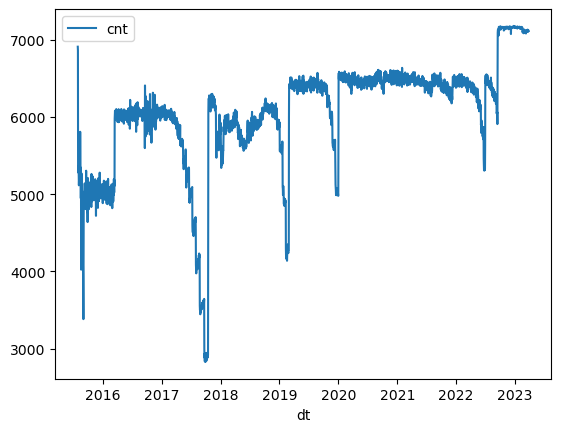

In [37]:
# 趋势图
block_count = block_count[block_count['dt'] > datetime.date(2015,1,1)]
block_count = block_count[block_count['dt'] < today_date]
_ = block_count.set_index('dt').plot()

最新的几个区块

In [38]:
## 当前时间
current_time = now()
str(current_time)

'2023-03-28 10:38:15.606464+00:00'

In [39]:
blocks = run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.blocks`
where date(timestamp) = '{today}'
order by number desc 
limit 5
''')
blocks

2023-03-28 10:38:15.711131+00:00

select *
from `bigquery-public-data.crypto_ethereum.blocks`
where date(timestamp) = '2023-03-28'
order by number desc 
limit 5

time: 6 seconds


,timestamp,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,miner,difficulty,total_difficulty,size,extra_data,gas_limit,gas_used,transaction_count,base_fee_per_gas
0,2023-03-28 10:34:11+00:00,16925270,0xde672679e486a2f5fd6acd7b43ad5dbb21c6f7e7ef03...,0x0d748ae27563eec5469e2c2f7fe49cf54466a6574bed...,0x0000000000000000,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x42bb11800905800b92605060a18b60abd42948494664...,0xd6ffe9b115f59c46a8b9f431310cb69cd622ebe9f66d...,0xd2af3574f267dd21986cae67d5d6552054429e04b8f1...,0xc4bede9b52817503a11d0558db7376856cbc50f8814f...,0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5,0E-9,58750003716598356000000.000000000,56306,0x6265617665726275696c642e6f7267,30000000,13767381,153,22613216952
1,2023-03-28 10:33:59+00:00,16925269,0x0d748ae27563eec5469e2c2f7fe49cf54466a6574bed...,0x51112f6ca5f4ab2cf9cc2cca90fd23f5861b64db6a7f...,0x0000000000000000,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0xd5a7c59e41ceb90eb8da95a0f13446b11023ec098d25...,0x1587010c47de927649fabd5f5629bfec71045b118c43...,0x1f9ebef3acd97997f5d512d030b347b356c528770788...,0x3bfb8dce3ffa45bf068cb254866bbb8fbc80deccdc06...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0E-9,58750003716598356000000.000000000,56293,0x6275696c64657230783639,30000000,18809257,189,21917472894
2,2023-03-28 10:33:47+00:00,16925268,0x51112f6ca5f4ab2cf9cc2cca90fd23f5861b64db6a7f...,0x61779cb6f23efcc436b452bca0431d7e243ef31dd9c9...,0x0000000000000000,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x6cb7a1cd5205aa0918b967b185116e6f5df4d01c1fa7...,0xcc4eb8612d05de00de97f4ba80b734347ef39977427d...,0x57807ab4fa11c4d875fd9e5716705e7044b6576f9439...,0x7de1f21a77a305232927e6a949e6309e81944824137d...,0xbaf6dc2e647aeb6f510f9e318856a1bcd66c5e19,0E-9,58750003716598356000000.000000000,225391,0x4d616465206f6e20746865206d6f6f6e20627920426c...,30000000,19806719,192,21073358617
3,2023-03-28 10:33:35+00:00,16925267,0x61779cb6f23efcc436b452bca0431d7e243ef31dd9c9...,0xc5b780e510e42923bf0e85c1822e168f512a8163dbce...,0x0000000000000000,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x19e301ee0560980a189c0ae08210f24f50a0c0dca124...,0xca03f69324b4bd747c2653aea1fbb09099a425e4a399...,0xec52fe370cf1c28934ac4d2e6d2446bc12d518eba6f7...,0x39d98b7763c84289eacf9e8a1b13f2a897984a7db2a9...,0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5,0E-9,58750003716598356000000.000000000,41956,0x6265617665726275696c642e6f7267,30000000,11415911,137,21722142723
4,2023-03-28 10:33:23+00:00,16925266,0xc5b780e510e42923bf0e85c1822e168f512a8163dbce...,0xee9412b0f2ef697ebea22fa4d769ac98d76d395a9e22...,0x0000000000000000,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0xe0a510244106be88175081a1e5506b6744f411188ea4...,0xff4a26df79effcbc825ad1588093d32a422a440ede5f...,0x2e0024651f7981121f9028402400bee353763b95ef83...,0x5d60f7aa3efc56a55c0377fa64e7734db1713f75e793...,0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5,0E-9,58750003716598356000000.000000000,53739,0x6265617665726275696c642e6f7267,30000000,12069416,153,22265910395


In [40]:
# 计算延迟
current_time - blocks['timestamp'][0]

Timedelta('0 days 00:04:04.606464')

#### 交易

最新的几个交易

In [41]:
run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.transactions`
where date(block_timestamp) = '{today}'
order by block_number desc 
limit 5
''')

2023-03-28 10:38:22.626330+00:00

select *
from `bigquery-public-data.crypto_ethereum.transactions`
where date(block_timestamp) = '2023-03-28'
order by block_number desc 
limit 5

time: 8 seconds


,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
0,0x4ff00c12e5ff1c05d34590cfc7f994513f1d95d5e9c5...,8417630,4,0x46340b20830761efd32832a74d7169b29feb9758,0x8bcb2c519b16b0822e7f02e0548cdaecc80460f8,196000000000000000.000000000,350000,32615636744,0x,340876,...,None,None,1,2023-03-28 10:34:23+00:00,16925271,0xfd4d33f6d481c7191bbccd3be2f29f71375862e09f98...,NaN,NaN,0,32615636744
1,0x3dc42d3db9205be85428d5da7d6a89e95edb5791e122...,4202424,34,0x9696f59e4d72e237be84ffd425dcad154bf96976,0x30b9e1ba9ac176c88cda6eaca7766db078f17224,231167400000000000.000000000,207128,24380937945,0x,2789263,...,None,None,1,2023-03-28 10:34:23+00:00,16925271,0xfd4d33f6d481c7191bbccd3be2f29f71375862e09f98...,1.020000e+11,2.000000e+09,2,24380937945
2,0x97591d84bafee3f08267aef0d9a32218e2d99603a3a0...,10,126,0xa405162f4273cb46e8c4a97f17d40d116fdae67e,0xfa5047c9c78b8877af97bdcb85db743fd7313d4a,0E-9,46446,22480937945,0x095ea7b3000000000000000000000000000000000022...,10138871,...,None,None,1,2023-03-28 10:34:23+00:00,16925271,0xfd4d33f6d481c7191bbccd3be2f29f71375862e09f98...,2.691285e+10,1.000000e+08,2,22480937945
3,0x2f7dd6be17743437ebc24815aac41bb5797710a07376...,8417631,5,0x46340b20830761efd32832a74d7169b29feb9758,0x62313a505a91cf71448c0a05a2837346f157eb8b,56000000000000000.000000000,350000,32615636744,0x,361876,...,None,None,1,2023-03-28 10:34:23+00:00,16925271,0xfd4d33f6d481c7191bbccd3be2f29f71375862e09f98...,NaN,NaN,0,32615636744
4,0x0cb5290ba5a7da3c5e31b7cf0b25df81a85d99fea17f...,20,67,0x6899799e5ac955bd59bda7d5fe79ecbac83597ad,0xf00db50415ccd13509046430b8c74a0831be90a3,29826911426862780.000000000,21000,23880937945,0x,4533089,...,None,None,1,2023-03-28 10:34:23+00:00,16925271,0xfd4d33f6d481c7191bbccd3be2f29f71375862e09f98...,4.364672e+10,1.500000e+09,2,23880937945


每年交易数量

In [42]:
transaction_count = run_sql('''
select *
from
(
  select extract(year from block_timestamp) year, count(*) transaction_count
  from `bigquery-public-data.crypto_ethereum.transactions`
  where extract(year from block_timestamp) >= 2015
  group by extract(year from block_timestamp)
)
order by year
''')
transaction_count

2023-03-28 10:38:31.296126+00:00

select *
from
(
  select extract(year from block_timestamp) year, count(*) transaction_count
  from `bigquery-public-data.crypto_ethereum.transactions`
  where extract(year from block_timestamp) >= 2015
  group by extract(year from block_timestamp)
)
order by year

time: 9 seconds


,year,transaction_count
0,2015,1046284
1,2016,13661080
2,2017,102941034
3,2018,251166529
4,2019,242832115
5,2020,344766970
6,2021,461807363
7,2022,408543268
8,2023,90625232


<AxesSubplot:xlabel='year'>

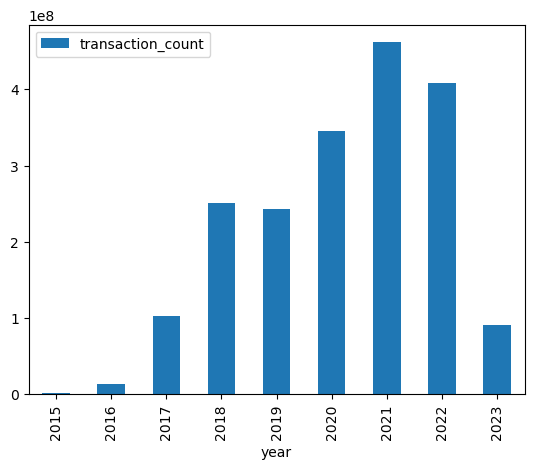

In [43]:
transaction_count.set_index('year').plot.bar()

#### ERC20（代币） / ERC721（NFT）

最近产生的几个token

In [44]:
tokens = run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.tokens`
where date(block_timestamp) >= '{yesterday}'
order by block_number desc 
limit 5
''')
tokens

2023-03-28 10:38:41.309986+00:00

select *
from `bigquery-public-data.crypto_ethereum.tokens`
where date(block_timestamp) >= '2023-03-27'
order by block_number desc 
limit 5

time: 1 seconds


,address,symbol,name,decimals,total_supply,block_timestamp,block_number,block_hash
0,0x94b52e3a2fe561daffe8f53f4c505615c38c7a4f,ZKP,ZKP,18,100000000000000000000000000,2023-03-28 10:11:11+00:00,16925158,0x8fa0375aed9ea8f98bc06b5b130ef33c556e586fc59c...
1,0xfd0523a6f7d840d7766de5efb5b391a4f7abded6,USDT,Tether USD,0,1550057494,2023-03-28 08:40:59+00:00,16924711,0x2654082219ae7dbd013a28967024574a9eb0b95c91cd...
2,0xab114d2cfe8f483bfa519106b7019af5a784d3f3,USDT-ERC20,USDT-ERC20,18,30000000000000000000000000000000,2023-03-28 05:29:59+00:00,16923774,0x3da7f3247ec42472d9af4ddfa083f801419e3f13d4f4...
3,0x5293d8a9181400e1ecc5c5a6969a36dfca2a1643,GDS,Gold Diggers,None,0,2023-03-28 04:25:47+00:00,16923456,0x2514388237cf9bbe56cf4a7251c567cf1e067c6f2b24...
4,0xcd06daa0c7ae2ba694d0a7db298161b8713ab879,CPESO,CPESO Token,18,10000000000000000000000000000000,2023-03-27 12:08:35+00:00,16918619,0xbecb00e0af320ee45f49be846c6ccafd99c0c7589ea6...


#### 通证交易

最新的几个通证交易

In [45]:
run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.token_transfers`
where date(block_timestamp) = '{today}'
order by block_number desc 
limit 5
''')

2023-03-28 10:38:42.575678+00:00

select *
from `bigquery-public-data.crypto_ethereum.token_transfers`
where date(block_timestamp) = '2023-03-28'
order by block_number desc 
limit 5

time: 7 seconds


,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash
0,0xf2e86384bfc42087c9661329060acbc041076824,0x0000000000000000000000000000000000000000,0x26c46e6f7b37e3eea85b6edf0e95583d0bb292ad,174,0x87f7e7bd9fb55bc7d4446d8f9be914d0ea48da321d16...,38,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
1,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,200000000000000000,0x42d6b6da150d841d5f7223979a17cadd54b12e67fd88...,179,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
2,0x2bd938cf96430b7b0879f76b010b589aeec2127c,0x0000000000000000000000000000000000000000,0x1a668b4b665de0af63fd84efea04a3acd4940b8d,49950,0xa56609362a3a2d182dff9ad12262cd0fa4b15d519651...,146,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
3,0xc944e90c64b2c07662a292be6244bdf05cda44a7,0x48c04ed5691981c42154c6167398f95e8f38a7ff,0x0c3805ccb47037a8533d34154cc3e8ff77e619f7,789265100260000000000,0x59e86573867af6d77dcd36a5042b7134e189763d7ab6...,78,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
4,0x5a98fcbea516cf06857215779fd812ca3bef1b32,0xe6effe1e71070435afeaf960c9baf471d0bb1d0a,0x28c6c06298d514db089934071355e5743bf21d60,103160000000000000000,0xcbb27f0a87e838e6a8d5b8b157f685cb919682213f37...,53,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...


#### 收据

BigQuery公共数据集中没有提供

#### 日志

最新的几条日志

In [46]:
run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.logs`
where date(block_timestamp) = '{today}'
order by block_number desc 
limit 5
''')

2023-03-28 10:38:49.577156+00:00

select *
from `bigquery-public-data.crypto_ethereum.logs`
where date(block_timestamp) = '2023-03-28'
order by block_number desc 
limit 5

time: 7 seconds


,log_index,transaction_hash,transaction_index,address,data,topics,block_timestamp,block_number,block_hash
0,194,0x929f5dfbfea6f5fc1d012933057b031ae8e1da365607...,128,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
1,272,0x52f05a4a90c981a82527b64db439573cf426e1091565...,165,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x00000000000000000000000000000000000000000000...,[0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98...,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
2,107,0x5484673ac23038c454683e9eb746d5d0a207691190df...,95,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x00000000000000000000000000000000000000000000...,[0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c4...,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
3,172,0xbb314654f0c2fab83ffa252981755517778db1843917...,115,0x2bd938cf96430b7b0879f76b010b589aeec2127c,0x,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...
4,102,0x5a6551fd04faec721ebdc5e388b12214ee772a5b8a8a...,94,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xd18e577cf125e9e8747af9aa59bd8a285d4df318d393...,[0x829fa99d94dc4636925b38632e625736a614c154d55...,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...


#### 合约

最新的几个合约

In [47]:
contracts = run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.contracts`
where date(block_timestamp) = '{today}'
order by block_number desc 
limit 5
''')
contracts

2023-03-28 10:38:56.562101+00:00

select *
from `bigquery-public-data.crypto_ethereum.contracts`
where date(block_timestamp) = '2023-03-28'
order by block_number desc 
limit 5

time: 7 seconds


,address,bytecode,function_sighashes,is_erc20,is_erc721,block_timestamp,block_number,block_hash
0,0x42070ac90c170ab937877c3126a3485de6fb8d8c,0x608060405234801561001057600080fd5b5060043610...,[],False,False,2023-03-28 10:33:59+00:00,16925269,0x0d748ae27563eec5469e2c2f7fe49cf54466a6574bed...
1,0xe9aa9b33383689f87f21c245f429bdb37867d9d3,0x363d3d373d3d3d363d73ee2c03ced8b6755e8d76ab14...,[],False,False,2023-03-28 10:33:59+00:00,16925269,0x0d748ae27563eec5469e2c2f7fe49cf54466a6574bed...
2,0xd2bf97788f4e0f1bcaace3cc53f64d36d91a191f,0x608060405273ffffffffffffffffffffffffffffffff...,[],False,False,2023-03-28 10:32:59+00:00,16925264,0xb3291c0e2f695360aecb7091bf0e494d254b16d82881...
3,0xeddefc6094feecf7eca9214b64f84795aed68c10,0x608060405260043610601f5760003560e01c80635c60...,[0x5c60da1b],False,False,2023-03-28 10:32:59+00:00,16925264,0xb3291c0e2f695360aecb7091bf0e494d254b16d82881...
4,0xd06bf6cb3567d3cfbb2acd28c24c664925dfc175,0x608060405273ffffffffffffffffffffffffffffffff...,[],False,False,2023-03-28 10:32:23+00:00,16925261,0x544e7a36958ac5b13ca0f5acec1b4e1278c30634f88d...


#### 内部交易

最新的几个内部交易

In [48]:
run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.traces`
where date(block_timestamp) = '{today}'
order by block_number desc 
limit 5
''')

2023-03-28 10:39:03.850671+00:00

select *
from `bigquery-public-data.crypto_ethereum.traces`
where date(block_timestamp) = '2023-03-28'
order by block_number desc 
limit 5

time: 11 seconds


,transaction_hash,transaction_index,from_address,to_address,value,input,output,trace_type,call_type,reward_type,gas,gas_used,subtraces,trace_address,error,status,block_timestamp,block_number,block_hash,trace_id
0,0xbcfeca62f706560f00fd0798795885a40e3cf00c1154...,141,0xd57474e76c9ebecc01b65a1494f0a1211df7bcd8,0x53a426781a70c4a84b5d64209920bc949a87b605,0E-9,0xa22cb4650000000000000000000000001e0049783f00...,0x,call,delegatecall,None,56907,37784,1,0,None,1,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...,call_0xbcfeca62f706560f00fd0798795885a40e3cf00...
1,0x9a4918927af462e19f6e500d04ffdc72abda0749eec9...,96,0x881d40237659c251811cec9c364ef91dc08d300c,0x74de5d4fcbf63e00296fd95d33236b9794016631,200000000000000000.000000000,0xe35473350000000000000000000000007cdf68ce9a05...,0x,call,call,None,155463,141868,1,0,None,1,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...,call_0x9a4918927af462e19f6e500d04ffdc72abda074...
2,0x62cb8a7d904da1da9c83354b1574e80eb525db25b019...,164,0x5e4e65926ba27467555eb562121fac00d24e9dd2,0xde1fcfb0851916ca5101820a69b13a4e276bd81f,0E-9,0xbf40fac1000000000000000000000000000000000000...,0x000000000000000000000000d16463ef9b0338ce3d73...,call,staticcall,None,155390,1284,0,4,None,1,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...,call_0x62cb8a7d904da1da9c83354b1574e80eb525db2...
3,0x9ec1643a5828f372a381d1d84d264928c74a707a3956...,16,0x18aaa7115705e8be94bffebde57af9bfc265b998,0x930c746a6e92ca8122682df48cd5020bc1771b32,0E-9,0x70a08231000000000000000000000000c730ef0f4973...,0x00000000000000000000000000000000000000000003...,call,delegatecall,None,203260,510,0,"2,1,0",None,1,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...,call_0x9ec1643a5828f372a381d1d84d264928c74a707...
4,0xcbb27f0a87e838e6a8d5b8b157f685cb919682213f37...,50,0x5a98fcbea516cf06857215779fd812ca3bef1b32,0xf73a1260d222f447210581ddf212d915c09a3249,0E-9,0x4a393149000000000000000000000000e6effe1e7107...,0x00000000000000000000000000000000000000000000...,call,call,None,222433,37314,2,0,None,1,2023-03-28 10:34:47+00:00,16925273,0xa427d1b302aff64579f26989bde6841d63a7dd8b2a59...,call_0xcbb27f0a87e838e6a8d5b8b157f685cb9196822...


今日内部交易数量

In [49]:
run_sql('''
select count(*)
from `bigquery-public-data.crypto_ethereum.traces`
where date(block_timestamp) = '{today}'
''')

2023-03-28 10:39:14.840994+00:00

select count(*)
from `bigquery-public-data.crypto_ethereum.traces`
where date(block_timestamp) = '2023-03-28'

time: 7 seconds


,f0_
0,2290311


### 4.2 数据洞察

https://github.com/blockchain-etl/awesome-bigquery-views

#### 余额最多的账户

In [50]:
run_sql('''
WITH double_entry_book AS (
    -- debits
    SELECT to_address AS address, value AS value
    FROM `bigquery-public-data.crypto_ethereum.traces`
    WHERE to_address IS NOT NULL
    AND status = 1
    AND (call_type NOT IN ('delegatecall', 'callcode', 'staticcall') OR call_type IS NULL)
    UNION ALL
    -- credits
    SELECT from_address AS address, -value AS value
    FROM `bigquery-public-data.crypto_ethereum.traces`
    WHERE from_address IS NOT NULL
    AND status = 1
    AND (call_type NOT IN ('delegatecall', 'callcode', 'staticcall') OR call_type IS NULL)
    UNION ALL
    -- transaction fees debits
    SELECT 
        miner AS address, 
        SUM(CAST(receipt_gas_used AS numeric) * CAST((receipt_effective_gas_price - COALESCE(base_fee_per_gas, 0)) as numeric)) AS value
    FROM `bigquery-public-data.crypto_ethereum.transactions` AS transactions
    join `bigquery-public-data.crypto_ethereum.blocks` AS blocks ON blocks.number = transactions.block_number
    GROUP BY blocks.number, blocks.miner
    UNION ALL
    -- transaction fees credits
    SELECT 
        from_address AS address, 
        -(CAST(receipt_gas_used AS numeric) * CAST(receipt_effective_gas_price AS numeric)) AS value
    FROM `bigquery-public-data.crypto_ethereum.transactions`
)
SELECT address, SUM(value) AS balance
FROM double_entry_book
GROUP BY address
ORDER BY balance DESC
LIMIT 5
''', print_sql=False)

2023-03-28 10:39:22.004538+00:00
time: 33 seconds


,address,balance
0,0x00000000219ab540356cbb839cbe05303d7705fa,17883175168232416675747075.000000000
1,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3793074418120871085470609.000000000
2,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,1996008283764188532048987.000000000
3,0xda9dfa130df4de4673b89022ee50ff26f6ea73cf,1780839974384348762870467.000000000
4,0x0716a17fbaee714f1e6ab0f9d59edbc5f09815c0,1636037377135017987539780.000000000


Google还提供了账户余额明细表

In [51]:
balance = run_sql('''
select *
from `bigquery-public-data.crypto_ethereum.balances`
order by eth_balance desc
limit 5
''', print_sql=False)
balance

2023-03-28 10:39:54.811387+00:00
time: 1 seconds


,address,eth_balance
0,0x00000000219ab540356cbb839cbe05303d7705fa,17866615163245128027575318.000000000
1,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3762692968379799353181856.000000000
2,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,1996008283764188532048987.000000000
3,0xda9dfa130df4de4673b89022ee50ff26f6ea73cf,1780839974384348762870467.000000000
4,0x0716a17fbaee714f1e6ab0f9d59edbc5f09815c0,1636037377135017987539780.000000000


* 0x00000000219ab540356cbb839cbe05303d7705fa: Beacon Deposit Contract  
* 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2: Wrapped Ether 
* 0xbe0eb53f46cd790cd13851d5eff43d12404d33e8: Binance

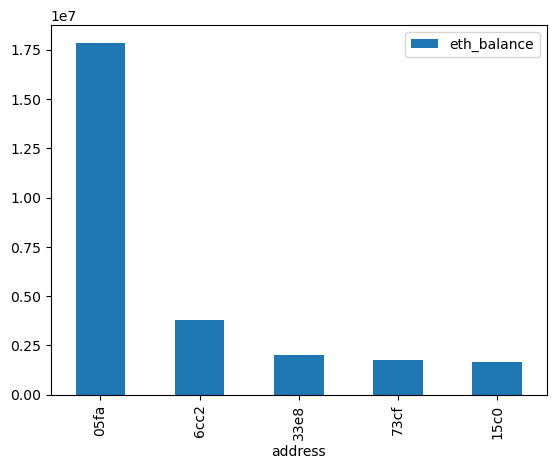

In [52]:
balance['address'] = balance['address'].str.slice(-4) # 取最后四个字符
balance['eth_balance'] = balance['eth_balance'].apply(float) / 1e18
_ = balance.set_index('address').plot.bar()

#### 以太币每日总供应量

In [53]:
supply = run_sql('''
WITH ether_emitted_by_date  AS (
  SELECT date(block_timestamp) AS date, SUM(value) AS value
  FROM `bigquery-public-data.crypto_ethereum.traces`
  WHERE trace_type IN ('genesis', 'reward')
  GROUP BY DATE(block_timestamp)
)
SELECT date, SUM(value) OVER (ORDER BY date) / POWER(10, 18) AS supply
FROM ether_emitted_by_date
''', print_sql=False)
supply

2023-03-28 10:39:56.773710+00:00
time: 11 seconds


,date,supply
0,1970-01-01,7.200999e+07
1,2015-07-30,7.204930e+07
2,2015-07-31,7.208549e+07
3,2015-08-01,7.211320e+07
4,2015-08-02,7.214142e+07
...,...,...
2795,2023-03-24,1.223739e+08
2796,2023-03-25,1.223739e+08
2797,2023-03-26,1.223739e+08
2798,2023-03-27,1.223739e+08


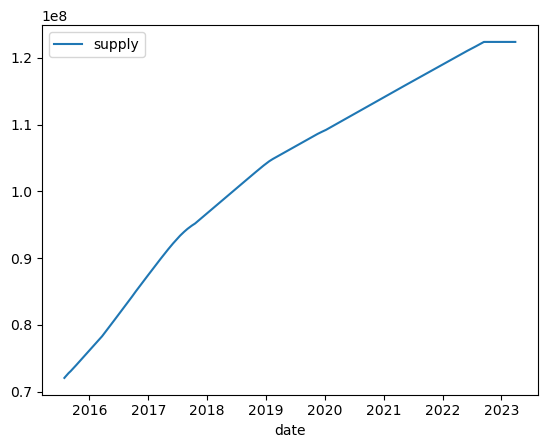

In [54]:
supply = supply[supply['date'] > datetime.date(2015,1,1)]
_ = supply.set_index('date').plot()

#### 两笔内部交易间最短路径

In [55]:
shortest_path = run_sql('''
DECLARE start_address STRING DEFAULT LOWER('0x47068105c5feff69e44520b251b9666d4b512a70');
DECLARE end_address STRING DEFAULT LOWER('0x2604afb5a64992e5abbf25865c9d3387ade92bad');

WITH traces_0 AS (
  SELECT *
  FROM `bigquery-public-data.crypto_ethereum.traces`
  WHERE from_address = start_address
),
traces_1_hop AS (
  SELECT
      1 AS hops,
      traces_1.from_address,
      traces_1.to_address,
      traces_1.trace_address,
      traces_1.block_timestamp,
      concat(traces_0.from_address, ' -> ', traces_0.to_address, ' -> ', traces_1.to_address) as path
  FROM `bigquery-public-data.crypto_ethereum.traces` AS traces_1
  INNER JOIN traces_0
  ON traces_0.to_address = traces_1.from_address
  AND traces_0.block_timestamp <= traces_1.block_timestamp 
),
traces_2_hops AS (
  SELECT
      2 AS hops,
      traces_2.from_address,
      traces_2.to_address,
      traces_2.trace_address,
      traces_2.block_timestamp,
      concat(path, ' -> ', traces_2.to_address) AS path
  FROM `bigquery-public-data.crypto_ethereum.traces` AS traces_2
  INNER JOIN traces_1_hop
  ON traces_1_hop.to_address = traces_2.from_address
  AND traces_1_hop.block_timestamp <= traces_2.block_timestamp 
),
traces_3_hops AS (
  SELECT
      3 AS hops,
      traces_3.from_address,
      traces_3.to_address,
      traces_3.trace_address,
      traces_2_hops.block_timestamp,
      concat(path, ' -> ', traces_3.to_address) AS path
  FROM `bigquery-public-data.crypto_ethereum.traces` AS traces_3
  INNER JOIN traces_2_hops
  ON traces_2_hops.to_address = traces_3.from_address
  AND traces_2_hops.block_timestamp <= traces_3.block_timestamp 
  WHERE traces_3.to_address = end_address
),
traces_all_hops AS (
    SELECT * FROM traces_1_hop
    UNION ALL
    SELECT * FROM traces_2_hops
    UNION ALL
    SELECT * FROM traces_3_hops
)
SELECT *
FROM traces_all_hops
WHERE hops = 3
LIMIT 5
''', print_sql=False)

shortest_path

2023-03-28 10:40:08.722006+00:00
time: 38 seconds


,hops,from_address,to_address,trace_address,block_timestamp,path
0,3,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2604afb5a64992e5abbf25865c9d3387ade92bad,4,2020-10-28 07:05:40+00:00,0x47068105c5feff69e44520b251b9666d4b512a70 -> ...
1,3,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2604afb5a64992e5abbf25865c9d3387ade92bad,4,2020-10-28 07:05:40+00:00,0x47068105c5feff69e44520b251b9666d4b512a70 -> ...
2,3,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2604afb5a64992e5abbf25865c9d3387ade92bad,4,2020-10-28 07:05:40+00:00,0x47068105c5feff69e44520b251b9666d4b512a70 -> ...
3,3,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2604afb5a64992e5abbf25865c9d3387ade92bad,4,2020-10-28 07:05:40+00:00,0x47068105c5feff69e44520b251b9666d4b512a70 -> ...
4,3,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2604afb5a64992e5abbf25865c9d3387ade92bad,4,2020-10-28 07:05:40+00:00,0x47068105c5feff69e44520b251b9666d4b512a70 -> ...


In [56]:
shortest_path['path'].iloc[0]

'0x47068105c5feff69e44520b251b9666d4b512a70 -> 0x9aab3f75489902f3a48495025729a0af77d4b11e -> 0x970b9bb2c0444f5e81e9d0efb84c8ccdcdcaf84d -> 0x7a250d5630b4cf539739df2c5dacb4c659f2488d -> 0x2604afb5a64992e5abbf25865c9d3387ade92bad'

#### 最近90天挖矿最多的几个账户

In [57]:
run_sql('''
WITH blocks_in AS (
                            SELECT * 
                            FROM  `bigquery-public-data.crypto_ethereum.blocks` 
                            WHERE   (DATE(timestamp      ) >= date_sub('{today}', INTERVAL 30 DAY ) )
                  )
               
-- *********************************************************************************************


SELECT
  miner,
  
  COUNT(miner) AS total_block_reward
FROM
  blocks_in
GROUP BY
  miner
HAVING
  COUNT(miner) > 1
ORDER BY
  total_block_reward desc
limit 5
''', print_sql=False)

2023-03-28 10:40:47.141682+00:00
time: 9 seconds


,miner,total_block_reward
0,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,43792
1,0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5,38167
2,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,35430
3,0x1f9090aae28b8a3dceadf281b0f12828e676c326,29501
4,0x388c818ca8b9251b393131c08a736a67ccb19297,12393


#### 不同区块链交易吞吐量对比

比较：Bitcoin、Bitcoin Cash、Ethereum、Ethereum Classic、Dogecoin、Litecoin、Dash、Zcash    
找出每种区块链交易TPS峰值，并按照峰值倒序排序

In [58]:
run_sql('''
WITH bitcoin_throughput AS (
    -- takes transactions count in every block and divides it by average block time on that day
    SELECT 'bitcoin' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
),
bitcoin_cash_throughput AS (
    SELECT 'bitcoin_cash' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_bitcoin_cash.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
),
ethereum_throughput AS (
    SELECT 'ethereum' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_ethereum.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
),
ethereum_classic_throughput AS (
    SELECT 'ethereum_classic' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_ethereum_classic.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
),
dogecoin_throughput AS (
    SELECT 'dogecoin' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_dogecoin.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
),
litecoin_throughput AS (
    SELECT 'litecoin' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_litecoin.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
),
dash_throughput AS (
    SELECT 'dash' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_dash.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
),
zcash_throughput AS (
    SELECT 'zcash' AS chain, count(*) / (24 * 60 * 60 / count(*) OVER (PARTITION BY DATE(block_timestamp))) AS throughput, block_timestamp AS time
    FROM `bigquery-public-data.crypto_zcash.transactions` AS transactions
    GROUP BY transactions.block_number, transactions.block_timestamp
    ORDER BY throughput DESC
    LIMIT 1
)
SELECT * FROM bitcoin_throughput
UNION ALL
SELECT * FROM bitcoin_cash_throughput
UNION ALL
SELECT * FROM ethereum_throughput
UNION ALL
SELECT * FROM ethereum_classic_throughput
UNION ALL
SELECT * FROM dogecoin_throughput
UNION ALL
SELECT * FROM litecoin_throughput
UNION ALL
SELECT * FROM dash_throughput
UNION ALL
SELECT * FROM zcash_throughput
ORDER BY throughput DESC
''', print_sql=False)

2023-03-28 10:40:56.594868+00:00
time: 17 seconds


,chain,throughput,time
0,bitcoin_cash,281.999676,2018-11-10 14:34:35+00:00
1,ethereum,116.875451,2022-12-23 20:18:59+00:00
2,dash,67.076319,2020-03-16 00:05:13+00:00
3,dogecoin,54.789282,2014-08-05 02:53:06+00:00
4,litecoin,49.419167,2019-11-02 18:43:59+00:00
5,ethereum_classic,23.739896,2019-01-13 08:09:56+00:00
6,bitcoin,21.956539,2015-08-01 01:06:41+00:00
7,zcash,7.876435,2018-08-03 02:08:54+00:00


## 5. 源码解读
### 5.1 下载源码

In [59]:
!rm -rf ethereum-etl
!git clone https://github.com/blockchain-etl/ethereum-etl

Cloning into 'ethereum-etl'...
remote: Enumerating objects: 5964, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5964 (delta 3), reused 2 (delta 1), pack-reused 5955
Receiving objects: 100% (5964/5964), 1.36 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (4183/4183), done.


### 5.2 JSON RPC 请求

In [60]:
!find ethereum-etl | grep .py | xargs grep -n jsonrpc | grep 2.0

ethereum-etl/ethereumetl/json_rpc_requests.py:63:        'jsonrpc': '2.0',


ethereumetl/json_rpc_requests.py

In [61]:
# %load ethereum-etl/ethereumetl/json_rpc_requests.py
# MIT License
#
# Copyright (c) 2018 Evgeny Medvedev, evge.medvedev@gmail.com
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


def generate_get_block_by_number_json_rpc(block_numbers, include_transactions):
    for idx, block_number in enumerate(block_numbers):
        yield generate_json_rpc(
            method='eth_getBlockByNumber',
            params=[hex(block_number), include_transactions],
            request_id=idx
        )


def generate_trace_block_by_number_json_rpc(block_numbers):
    for block_number in block_numbers:
        yield generate_json_rpc(
            method='debug_traceBlockByNumber',
            params=[hex(block_number), {'tracer': 'callTracer'}],
            # save block_number in request ID, so later we can identify block number in response
            request_id=block_number,
        )


def generate_get_receipt_json_rpc(transaction_hashes):
    for idx, transaction_hash in enumerate(transaction_hashes):
        yield generate_json_rpc(
            method='eth_getTransactionReceipt',
            params=[transaction_hash],
            request_id=idx
        )


def generate_get_code_json_rpc(contract_addresses, block='latest'):
    for idx, contract_address in enumerate(contract_addresses):
        yield generate_json_rpc(
            method='eth_getCode',
            params=[contract_address, hex(block) if isinstance(block, int) else block],
            request_id=idx
        )


def generate_json_rpc(method, params, request_id=1):
    return {
        'jsonrpc': '2.0',
        'method': method,
        'params': params,
        'id': request_id,
    }

### 5.3 jobs

In [62]:
!grep method= ethereum-etl/ethereumetl/json_rpc_requests.py

            method='eth_getBlockByNumber',
            method='debug_traceBlockByNumber',
            method='eth_getTransactionReceipt',
            method='eth_getCode',


In [63]:
!grep -nr "generate_.*json_rpc" ethereum-etl | grep -v json_rpc_requests.py

ethereum-etl/ethereumetl/jobs/export_blocks_job.py:28:from ethereumetl.json_rpc_requests import generate_get_block_by_number_json_rpc
ethereum-etl/ethereumetl/jobs/export_blocks_job.py:74:        blocks_rpc = list(generate_get_block_by_number_json_rpc(block_number_batch, self.export_transactions))
ethereum-etl/ethereumetl/jobs/export_contracts_job.py:28:from ethereumetl.json_rpc_requests import generate_get_code_json_rpc
ethereum-etl/ethereumetl/jobs/export_contracts_job.py:60:        contracts_code_rpc = list(generate_get_code_json_rpc(contract_addresses))
ethereum-etl/ethereumetl/jobs/export_geth_traces_job.py:26:from ethereumetl.json_rpc_requests import generate_trace_block_by_number_json_rpc
ethereum-etl/ethereumetl/jobs/export_geth_traces_job.py:64:        trace_block_rpc = list(generate_trace_block_by_number_json_rpc(block_number_batch))
ethereum-etl/ethereumetl/jobs/export_receipts_job.py:28:from ethereumetl.json_rpc_requests import generate_get_receipt_json_rpc
ethereum-etl/eth

export_all  

![](flowchart.png)

### 5.4 common

blockchainetl/jobs/base_job.py

```python
class BaseJob:
    def run(self):
        try:
            self._start()
            self._export()
        finally:
            self._end()
        
    def _start
    def _export
    def _end
```

ethereumetl/providers/ipc.py

```python
from web3.providers.ipc import IPCProvider
class BatchIPCProvider(IPCProvider):
    def make_batch_request(self, text)
```

ethereumetl/providers/rpc.py

```python
from web3 import HTTPProvider
from web3._utils.request import make_post_request
class BatchHTTPProvider(HTTPProvider):
     def make_batch_request(self, text)
```

ethereumetl/providers/auto.py
```python
def get_provider_from_uri(uri_string, timeout=DEFAULT_TIMEOUT, batch=False):
    uri = urlparse(uri_string)
    if uri.scheme == 'file':
        if batch:
            return BatchIPCProvider(uri.path, timeout=timeout)
        else:
            return IPCProvider(uri.path, timeout=timeout)
    elif uri.scheme == 'http' or uri.scheme == 'https':
        request_kwargs = {'timeout': timeout}
        if batch:
            return BatchHTTPProvider(uri_string, request_kwargs=request_kwargs)
        else:
            return HTTPProvider(uri_string, request_kwargs=request_kwargs)
    else:
        raise ValueError('Unknown uri scheme {}'.format(uri_string))
```

### 5.5 blocks & transactions

`eth_getBlockByNumber`

ethereumetl/domain/transaction.py

```python
class EthTransaction(object):
    def __init__(self):
        self.hash = None
        self.nonce = None
        self.block_hash = None
        self.block_number = None
        self.transaction_index = None
        self.from_address = None
        self.to_address = None
        self.value = None
        self.gas = None
        self.gas_price = None
        self.input = None
        self.max_fee_per_gas = None
        self.max_priority_fee_per_gas = None
        self.transaction_type = None
```

ethereumetl/mappers/transaction_mapper.py

```python
class EthTransactionMapper(object):
    def json_dict_to_transaction(self, json_dict, **kwargs)
    def transaction_to_dict(self, transaction)
```

ethereumetl/domain/block.py
```python
class EthBlock(object):
    def __init__(self):
        self.number = None
        self.hash = None
        self.parent_hash = None
        self.nonce = None
        self.sha3_uncles = None
        self.logs_bloom = None
        self.transactions_root = None
        self.state_root = None
        self.receipts_root = None
        self.miner = None
        self.difficulty = None
        self.total_difficulty = None
        self.size = None
        self.extra_data = None
        self.gas_limit = None
        self.gas_used = None
        self.timestamp = None

        self.transactions = []
        self.transaction_count = 0
        self.base_fee_per_gas = 0
```

ethereumetl/mappers/block_mapper.py

```python
class EthBlockMapper(object):
    def __init__(self, transaction_mapper=None):
        if transaction_mapper is None:
            self.transaction_mapper = EthTransactionMapper()
        else:
            self.transaction_mapper = transaction_mapper
            
    def json_dict_to_block(self, json_dict)
    def block_to_dict(self, block)
```

ethereumetl/jobs/export_blocks_job.py


```python
# Exports blocks and transactions
class ExportBlocksJob(BaseJob):
    def __init__(
            self,
            start_block,
            end_block,
            batch_size,
            batch_web3_provider,
            max_workers,
            item_exporter,
            export_blocks=True,
            export_transactions=True):
        validate_range(start_block, end_block)

        self.block_mapper = EthBlockMapper()
        self.transaction_mapper = EthTransactionMapper()

    def _export(self):
        self.batch_work_executor.execute(
            range(self.start_block, self.end_block + 1),
            self._export_batch,
            total_items=self.end_block - self.start_block + 1
        )

    def _export_batch(self, block_number_batch):
        blocks_rpc = list(generate_get_block_by_number_json_rpc(block_number_batch, self.export_transactions)) # eth_getBlockByNumber
        response = self.batch_web3_provider.make_batch_request(json.dumps(blocks_rpc))
        results = rpc_response_batch_to_results(response)
        blocks = [self.block_mapper.json_dict_to_block(result) for result in results]

        for block in blocks:
            self._export_block(block)

    def _export_block(self, block):
        if self.export_blocks:
            self.item_exporter.export_item(self.block_mapper.block_to_dict(block)) # 导出区块
        if self.export_transactions:
            for tx in block.transactions:
                self.item_exporter.export_item(self.transaction_mapper.transaction_to_dict(tx)) # 导出交易
```

ethereumetl/jobs/export_all_common.py

```python
def export_all_common(partitions, output_dir, provider_uri, max_workers, batch_size):
    blocks_output_dir = '{output_dir}/blocks{partition_dir}'.format(
            output_dir=output_dir,
            partition_dir=partition_dir,
        )
    blocks_file = '{blocks_output_dir}/blocks_{file_name_suffix}.csv'.format(
            blocks_output_dir=blocks_output_dir,
            file_name_suffix=file_name_suffix,
        )
    job = ExportBlocksJob(
            start_block=batch_start_block,
            end_block=batch_end_block,
            batch_size=batch_size,
            batch_web3_provider=ThreadLocalProxy(lambda: get_provider_from_uri(provider_uri, batch=True)),
            max_workers=max_workers,
            item_exporter=blocks_and_transactions_item_exporter(blocks_file, transactions_file),
            export_blocks=blocks_file is not None,
            export_transactions=transactions_file is not None)
    job.run()
```

### 5.6 token transfers

`eth_getFilterLogs`

ethereumetl/domain/receipt_log.py

```python
class EthReceiptLog(object):
    def __init__(self):
        self.log_index = None
        self.transaction_hash = None
        self.transaction_index = None
        self.block_hash = None
        self.block_number = None
        self.address = None
        self.data = None
        self.topics = []
```

ethereumetl/mappers/receipt_log_mapper.py

```python
class EthReceiptLogMapper(object):

    def json_dict_to_receipt_log(self, json_dict)
    def web3_dict_to_receipt_log(self, dict)
    def receipt_log_to_dict(self, receipt_log)
    def dict_to_receipt_log(self, dict)
```

ethereumetl/domain/token_transfer.py

```python
class EthTokenTransfer(object):
    def __init__(self):
        self.token_address = None
        self.from_address = None
        self.to_address = None
        self.value = None
        self.transaction_hash = None
        self.log_index = None
        self.block_number = None
```

ethereumetl/mappers/token_transfer_mapper.py

```python
class EthTokenTransferMapper(object):
    def token_transfer_to_dict(self, token_transfer)
```

ethereumetl/service/token_transfer_extractor.py

```python
# https://ethereum.stackexchange.com/questions/12553/understanding-logs-and-log-blooms
TRANSFER_EVENT_TOPIC = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'

class EthTokenTransferExtractor(object):
    def extract_transfer_from_log(self, receipt_log):

        topics = receipt_log.topics
        if topics is None or len(topics) < 1:
            # This is normal, topics can be empty for anonymous events
            return None

        if (topics[0]).casefold() == TRANSFER_EVENT_TOPIC:
            # Handle unindexed event fields
            topics_with_data = topics + split_to_words(receipt_log.data)
            # if the number of topics and fields in data part != 4, then it's a weird event
            if len(topics_with_data) != 4:
                logger.warning("The number of topics and data parts is not equal to 4 in log {} of transaction {}"
                               .format(receipt_log.log_index, receipt_log.transaction_hash))
                return None

            token_transfer = EthTokenTransfer()
            token_transfer.token_address = to_normalized_address(receipt_log.address)
            token_transfer.from_address = word_to_address(topics_with_data[1])
            token_transfer.to_address = word_to_address(topics_with_data[2])
            token_transfer.value = hex_to_dec(topics_with_data[3])
            token_transfer.transaction_hash = receipt_log.transaction_hash
            token_transfer.log_index = receipt_log.log_index
            token_transfer.block_number = receipt_log.block_number
            return token_transfer

        return None
```

ethereumetl/jobs/export_token_transfers_job.py

```python
class ExportTokenTransfersJob(BaseJob):
    def __init__(
            self,
            start_block,
            end_block,
            batch_size,
            web3,
            item_exporter,
            max_workers,
            tokens=None):
        
        self.receipt_log_mapper = EthReceiptLogMapper()
        self.token_transfer_mapper = EthTokenTransferMapper()
        self.token_transfer_extractor = EthTokenTransferExtractor()
        self._supports_eth_newFilter = True

    def _export(self):
        self.batch_work_executor.execute(
            range(self.start_block, self.end_block + 1),
            self._export_batch,
            total_items=self.end_block - self.start_block + 1
        )

    def _export_batch(self, block_number_batch):
        assert len(block_number_batch) > 0
        # https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterlogs
        filter_params = {
            'fromBlock': block_number_batch[0],
            'toBlock': block_number_batch[-1],
            'topics': [TRANSFER_EVENT_TOPIC]
        }

        if self.tokens is not None and len(self.tokens) > 0:
            filter_params['address'] = self.tokens

        try:
            event_filter = self.web3.eth.filter(filter_params)  # eth_getFilterLogs
            events = event_filter.get_all_entries()
        except ValueError as e:
            if str(e) == "{'code': -32000, 'message': 'the method is currently not implemented: eth_newFilter'}":
                self._supports_eth_newFilter = False
                events = self.web3.eth.getLogs(filter_params)
            else:
                raise(e)
        for event in events:
            log = self.receipt_log_mapper.web3_dict_to_receipt_log(event)
            token_transfer = self.token_transfer_extractor.extract_transfer_from_log(log)
            if token_transfer is not None:
                self.item_exporter.export_item(self.token_transfer_mapper.token_transfer_to_dict(token_transfer)) # 导出通证交易

        if self._supports_eth_newFilter:
            self.web3.eth.uninstallFilter(event_filter.filter_id)
```

ethereumetl/jobs/export_all_common.py

```python
def export_all_common(partitions, output_dir, provider_uri, max_workers, batch_size):

    for batch_start_block, batch_end_block, partition_dir in partitions:

        token_transfers_file = None
        if is_log_filter_supported(provider_uri):
            token_transfers_output_dir = '{output_dir}/token_transfers{partition_dir}'.format(
                output_dir=output_dir,
                partition_dir=partition_dir,
            )

            token_transfers_file = '{token_transfers_output_dir}/token_transfers_{file_name_suffix}.csv'.format(
                token_transfers_output_dir=token_transfers_output_dir,
                file_name_suffix=file_name_suffix,
            )

            job = ExportTokenTransfersJob(
                start_block=batch_start_block,
                end_block=batch_end_block,
                batch_size=batch_size,
                web3=ThreadLocalProxy(lambda: build_web3(get_provider_from_uri(provider_uri))),
                item_exporter=token_transfers_item_exporter(token_transfers_file),
                max_workers=max_workers)
            job.run()
```

### 5.7 receipts & logs

`eth_getTransactionReceipt`

ethereumetl/domain/receipt_log.py

```python
class EthReceiptLog(object):
    def __init__(self):
        self.log_index = None
        self.transaction_hash = None
        self.transaction_index = None
        self.block_hash = None
        self.block_number = None
        self.address = None
        self.data = None
        self.topics = []
```

ethereumetl/mappers/receipt_log_mapper.py

```python
class EthReceiptLogMapper(object):

    def json_dict_to_receipt_log(self, json_dict)
    def web3_dict_to_receipt_log(self, dict)
    def receipt_log_to_dict(self, receipt_log)
    def dict_to_receipt_log(self, dict)
```

ethereumetl/domain/receipt.py

```python
class EthReceipt(object):
    def __init__(self):
        self.transaction_hash = None
        self.transaction_index = None
        self.block_hash = None
        self.block_number = None
        self.cumulative_gas_used = None
        self.gas_used = None
        self.contract_address = None
        self.logs = []
        self.root = None
        self.status = None
        self.effective_gas_price = None
```

ethereumetl/mappers/receipt_mapper.py

```python
class EthReceiptMapper(object):
    def json_dict_to_receipt(self, json_dict)
    def receipt_to_dict(self, receipt)
```

ethereumetl/jobs/export_receipts_job.py

```python
class ExportReceiptsJob(BaseJob):
    def __init__(
            self,
            transaction_hashes_iterable,
            batch_size,
            batch_web3_provider,
            max_workers,
            item_exporter,
            export_receipts=True,
            export_logs=True):

        self.receipt_mapper = EthReceiptMapper()
        self.receipt_log_mapper = EthReceiptLogMapper()

    def _export(self):
        self.batch_work_executor.execute(self.transaction_hashes_iterable, self._export_receipts)

    def _export_receipts(self, transaction_hashes):
        receipts_rpc = list(generate_get_receipt_json_rpc(transaction_hashes)) # eth_getTransactionReceipt
        response = self.batch_web3_provider.make_batch_request(json.dumps(receipts_rpc))
        results = rpc_response_batch_to_results(response)
        receipts = [self.receipt_mapper.json_dict_to_receipt(result) for result in results]
        for receipt in receipts:
            self._export_receipt(receipt)

    def _export_receipt(self, receipt):
        if self.export_receipts:
            self.item_exporter.export_item(self.receipt_mapper.receipt_to_dict(receipt)) # 导出收据
        if self.export_logs:
            for log in receipt.logs:
                self.item_exporter.export_item(self.receipt_log_mapper.receipt_log_to_dict(log)) # 导出日志
```

ethereumetl/jobs/export_all_common.py

```python
def export_all_common(partitions, output_dir, provider_uri, max_workers, batch_size):
    transaction_hashes_file = '{cache_output_dir}/transaction_hashes_{file_name_suffix}.csv'.format(
        cache_output_dir=cache_output_dir,
        file_name_suffix=file_name_suffix,
    )
    extract_csv_column_unique(transactions_file, transaction_hashes_file, 'hash')
    
    receipts_output_dir = '{output_dir}/receipts{partition_dir}'.format(
        output_dir=output_dir,
        partition_dir=partition_dir,
    )
    
    receipts_file = '{receipts_output_dir}/receipts_{file_name_suffix}.csv'.format(
        receipts_output_dir=receipts_output_dir,
        file_name_suffix=file_name_suffix,
    )
    
     with smart_open(transaction_hashes_file, 'r') as transaction_hashes:
            job = ExportReceiptsJob(
                transaction_hashes_iterable=(transaction_hash.strip() for transaction_hash in transaction_hashes),
                batch_size=batch_size,
                batch_web3_provider=ThreadLocalProxy(lambda: get_provider_from_uri(provider_uri, batch=True)),
                max_workers=max_workers,
                item_exporter=receipts_and_logs_item_exporter(receipts_file, logs_file),
                export_receipts=receipts_file is not None,
                export_logs=logs_file is not None)
            job.run()
```

### 5.8 contracts

`eth_getCode`

ethereumetl/domain/contract.py

```python
class EthContract(object):
    def __init__(self):
        self.address = None
        self.bytecode = None
        self.function_sighashes = []
        self.is_erc20 = False
        self.is_erc721 = False
        self.block_number = None
```

ethereumetl/mappers/contract_mapper.py

```python
class EthContractMapper(object):

    def rpc_result_to_contract
    def contract_to_dict
```

ethereumetl/service/eth_contract_service.py

```python
from eth_utils import function_signature_to_4byte_selector
from ethereum_dasm.evmdasm import EvmCode, Contract

class EthContractService:

    def get_function_sighashes(self, bytecode)

    def is_erc20_contract(self, function_sighashes): # 代币
        c = ContractWrapper(function_sighashes)
        return c.implements('totalSupply()') and \
               c.implements('balanceOf(address)') and \
               c.implements('transfer(address,uint256)') and \
               c.implements('transferFrom(address,address,uint256)') and \
               c.implements('approve(address,uint256)') and \
               c.implements('allowance(address,address)')

    def is_erc721_contract(self, function_sighashes): # NFT
        c = ContractWrapper(function_sighashes)
        return c.implements('balanceOf(address)') and \
               c.implements('ownerOf(uint256)') and \
               c.implements_any_of('transfer(address,uint256)', 'transferFrom(address,address,uint256)') and \
               c.implements('approve(address,uint256)')
```


ethereumetl/jobs/export_contracts_job.py

```python
class ExportContractsJob(BaseJob):
    def __init__(
            self,
            contract_addresses_iterable,
            batch_size,
            batch_web3_provider,
            max_workers,
            item_exporter):

        self.contract_service = EthContractService()
        self.contract_mapper = EthContractMapper()
        
    def _export_contracts(self, contract_addresses):
        contracts_code_rpc = list(generate_get_code_json_rpc(contract_addresses)) # eth_getCode
        response_batch = self.batch_web3_provider.make_batch_request(json.dumps(contracts_code_rpc))

        contracts = []
        for response in response_batch:
            # request id is the index of the contract address in contract_addresses list
            request_id = response['id']
            result = rpc_response_to_result(response)

            contract_address = contract_addresses[request_id]
            contract = self._get_contract(contract_address, result)
            contracts.append(contract)

        for contract in contracts:
            self.item_exporter.export_item(self.contract_mapper.contract_to_dict(contract)) # 导出合约

    def _get_contract(self, contract_address, rpc_result):
        contract = self.contract_mapper.rpc_result_to_contract(contract_address, rpc_result)
        bytecode = contract.bytecode
        function_sighashes = self.contract_service.get_function_sighashes(bytecode)

        contract.function_sighashes = function_sighashes
        contract.is_erc20 = self.contract_service.is_erc20_contract(function_sighashes) # 代币
        contract.is_erc721 = self.contract_service.is_erc721_contract(function_sighashes) # NFT

        return contract
```

ethereumetl/jobs/export_all_common.py

```python
def export_all_common(partitions, output_dir, provider_uri, max_workers, batch_size):

    contract_addresses_file = '{cache_output_dir}/contract_addresses_{file_name_suffix}.csv'.format(
        cache_output_dir=cache_output_dir,
        file_name_suffix=file_name_suffix,
    )
        
    extract_csv_column_unique(receipts_file, contract_addresses_file, 'contract_address')

    contracts_output_dir = '{output_dir}/contracts{partition_dir}'.format(
        output_dir=output_dir,
        partition_dir=partition_dir,
    )

    contracts_file = '{contracts_output_dir}/contracts_{file_name_suffix}.csv'.format(
        contracts_output_dir=contracts_output_dir,
        file_name_suffix=file_name_suffix,
    )

    with smart_open(contract_addresses_file, 'r') as contract_addresses_file:
        contract_addresses = (contract_address.strip() for contract_address in contract_addresses_file
                              if contract_address.strip())
        job = ExportContractsJob(
            contract_addresses_iterable=contract_addresses,
            batch_size=batch_size,
            batch_web3_provider=ThreadLocalProxy(lambda: get_provider_from_uri(provider_uri, batch=True)),
                item_exporter=contracts_item_exporter(contracts_file),
                max_workers=max_workers)
        job.run()
```

### 5.9 tokens

ethereumetl/domain/token.py

```python
class EthToken(object):
    def __init__(self):
        self.address = None
        self.symbol = None
        self.name = None
        self.decimals = None
        self.total_supply = None
        self.block_number = None
```

ethereumetl/mappers/token_mapper.py

```python
class EthTokenMapper(object):
    def token_to_dict(self, token)
```

ethereumetl/service/eth_token_service.py

```python
from web3.exceptions import BadFunctionCallOutput, ContractLogicError

from ethereumetl.domain.token import EthToken
from ethereumetl.erc20_abi import ERC20_ABI, ERC20_ABI_ALTERNATIVE_1

class EthTokenService(object):
    def __init__(self, web3, function_call_result_transformer=None):
        self._web3 = web3
        self._function_call_result_transformer = function_call_result_transformer

    def get_token(self, token_address):
        checksum_address = self._web3.toChecksumAddress(token_address)
        contract = self._web3.eth.contract(address=checksum_address, abi=ERC20_ABI)
        contract_alternative_1 = self._web3.eth.contract(address=checksum_address, abi=ERC20_ABI_ALTERNATIVE_1)

        symbol = self._get_first_result(
            contract.functions.symbol(),
            contract.functions.SYMBOL(),
            contract_alternative_1.functions.symbol(),
            contract_alternative_1.functions.SYMBOL(),
        )
        if isinstance(symbol, bytes):
            symbol = self._bytes_to_string(symbol)

        name = self._get_first_result(
            contract.functions.name(),
            contract.functions.NAME(),
            contract_alternative_1.functions.name(),
            contract_alternative_1.functions.NAME(),
        )
        if isinstance(name, bytes):
            name = self._bytes_to_string(name)

        decimals = self._get_first_result(contract.functions.decimals(), contract.functions.DECIMALS())
        total_supply = self._get_first_result(contract.functions.totalSupply())

        token = EthToken()
        token.address = token_address
        token.symbol = symbol
        token.name = name
        token.decimals = decimals
        token.total_supply = total_supply

        return token

    def _get_first_result(self, *funcs):
        for func in funcs:
            result = self._call_contract_function(func)
            if result is not None:
                return result
        return None

    def _call_contract_function(self, func):
        # BadFunctionCallOutput exception happens if the token doesn't implement a particular function
        # or was self-destructed
        # OverflowError exception happens if the return type of the function doesn't match the expected type
        result = call_contract_function(
            func=func,
            ignore_errors=(BadFunctionCallOutput, ContractLogicError, OverflowError, ValueError),
            default_value=None)

        if self._function_call_result_transformer is not None:
            return self._function_call_result_transformer(result)
        else:
            return result

    def _bytes_to_string(self, b, ignore_errors=True):
        if b is None:
            return b

        try:
            b = b.decode('utf-8')
        except UnicodeDecodeError as e:
            if ignore_errors:
                logger.debug('A UnicodeDecodeError exception occurred while trying to decode bytes to string', exc_info=True)
                b = None
            else:
                raise e

        if self._function_call_result_transformer is not None:
            b = self._function_call_result_transformer(b)
        return b


def call_contract_function(func, ignore_errors, default_value=None):
    try:
        result = func.call()
        return result
    except Exception as ex:
        if type(ex) in ignore_errors:
            logger.debug('An exception occurred in function {} of contract {}. '.format(func.fn_name, func.address)
                             + 'This exception can be safely ignored.', exc_info=True)
            return default_value
        else:
            raise ex
```

ethereumetl/jobs/export_tokens_job.py

```python
class ExportTokensJob(BaseJob):
    def __init__(self, web3, item_exporter, token_addresses_iterable, max_workers):
        self.token_service = EthTokenService(web3, clean_user_provided_content)
        self.token_mapper = EthTokenMapper()

    def _export(self):
        self.batch_work_executor.execute(self.token_addresses_iterable, self._export_tokens)

    def _export_tokens(self, token_addresses):
        for token_address in token_addresses:
            self._export_token(token_address)

    def _export_token(self, token_address, block_number=None):
        token = self.token_service.get_token(token_address)
        token.block_number = block_number
        token_dict = self.token_mapper.token_to_dict(token)
        self.item_exporter.export_item(token_dict) # 导出token
```

ethereumetl/jobs/export_all_common.py

```python
def export_all_common(partitions, output_dir, provider_uri, max_workers, batch_size):
    if token_transfers_file is not None:
        token_addresses_file = '{cache_output_dir}/token_addresses_{file_name_suffix}'.format(
            cache_output_dir=cache_output_dir,
            file_name_suffix=file_name_suffix,
        )
        
        extract_csv_column_unique(token_transfers_file, token_addresses_file, 'token_address')

        tokens_output_dir = '{output_dir}/tokens{partition_dir}'.format(
            output_dir=output_dir,
            partition_dir=partition_dir,
        )

        tokens_file = '{tokens_output_dir}/tokens_{file_name_suffix}.csv'.format(
            tokens_output_dir=tokens_output_dir,
            file_name_suffix=file_name_suffix,
        )

        with smart_open(token_addresses_file, 'r') as token_addresses:
            job = ExportTokensJob(
                token_addresses_iterable=(token_address.strip() for token_address in token_addresses),
                web3=ThreadLocalProxy(lambda: build_web3(get_provider_from_uri(provider_uri))),
                item_exporter=tokens_item_exporter(tokens_file),
                max_workers=max_workers)
            job.run()
```

### 5.10 traces

`trace_block`

ethereumetl/domain/trace.py

```python
class EthTrace(object):
    def __init__(self):
        self.block_number = None
        self.transaction_hash = None
        self.transaction_index = None
        self.from_address = None
        self.to_address = None
        self.value = None
        self.input = None
        self.output = None
        self.trace_type = None
        self.call_type = None
        self.reward_type = None
        self.gas = None
        self.gas_used = None
        self.subtraces = 0
        self.trace_address = None
        self.error = None
        self.status = None
        self.trace_id = None
        self.trace_index = None
```

ethereumetl/mappers/trace_mapper.py

```python
class EthTraceMapper(object):
    def json_dict_to_trace(self, json_dict)
    def geth_trace_to_traces(self, geth_trace)
    def genesis_alloc_to_trace(self, allocation)
    def daofork_state_change_to_trace(self, state_change)
    def trace_to_dict(self, trace)
```

In [64]:
from ethereumetl.mainnet_genesis_alloc import MAINNET_GENESIS_ALLOC 
print(len(MAINNET_GENESIS_ALLOC))
MAINNET_GENESIS_ALLOC[0] # to_address, value

8893


('0x3282791d6fd713f1e94f4bfd565eaa78b3a0599d', 1337000000000000000000)

In [65]:
from ethereumetl.mainnet_daofork_state_changes import MAINNET_DAOFORK_STATE_CHANGES
print(len(MAINNET_DAOFORK_STATE_CHANGES))
MAINNET_DAOFORK_STATE_CHANGES[0] # from_address, to_address, value

116


('0x005f5cee7a43331d5a3d3eec71305925a62f34b6',
 '0xbf4ed7b27f1d666546e30d74d50d173d20bca754',
 0)

ethereumetl/service/eth_special_trace_service.py

```python
class EthSpecialTraceService(object):

    def __init__(self):
        self.trace_mapper = EthTraceMapper()

    def get_genesis_traces(self):
        from ethereumetl.mainnet_genesis_alloc import MAINNET_GENESIS_ALLOC
        genesis_traces = [self.trace_mapper.genesis_alloc_to_trace(alloc)
                          for alloc in MAINNET_GENESIS_ALLOC]
        return genesis_traces

    def get_daofork_traces(self):
        from ethereumetl.mainnet_daofork_state_changes import MAINNET_DAOFORK_STATE_CHANGES
        daofork_traces = [self.trace_mapper.daofork_state_change_to_trace(change)
                          for change in MAINNET_DAOFORK_STATE_CHANGES]
        return daofork_traces
```

ethereumetl/jobs/export_traces_job.py

```python
class ExportTracesJob(BaseJob):
    def __init__(
            self,
            start_block,
            end_block,
            batch_size,
            web3,
            item_exporter,
            max_workers,
            include_genesis_traces=False,
            include_daofork_traces=False):
       
        self.trace_mapper = EthTraceMapper()
        self.special_trace_service = EthSpecialTraceService()
        
    def _export(self):
        self.batch_work_executor.execute(
            range(self.start_block, self.end_block + 1),
            self._export_batch,
            total_items=self.end_block - self.start_block + 1
        )

    def _export_batch(self, block_number_batch):
        # TODO: Change to len(block_number_batch) > 0 when this issue is fixed
        # https://github.com/paritytech/parity-ethereum/issues/9822
        assert len(block_number_batch) == 1
        block_number = block_number_batch[0]

        all_traces = []

        if self.include_genesis_traces and 0 in block_number_batch:
            genesis_traces = self.special_trace_service.get_genesis_traces()
            all_traces.extend(genesis_traces)

        if self.include_daofork_traces and DAOFORK_BLOCK_NUMBER in block_number_batch:
            daofork_traces = self.special_trace_service.get_daofork_traces()
            all_traces.extend(daofork_traces)

        # TODO: Change to traceFilter when this issue is fixed
        # https://github.com/paritytech/parity-ethereum/issues/9822
        json_traces = self.web3.parity.traceBlock(block_number) # trace_block

        if json_traces is None:
            raise ValueError('Response from the node is None. Is the node fully synced? Is the node started with tracing enabled? Is trace_block API enabled?')

        traces = [self.trace_mapper.json_dict_to_trace(json_trace) for json_trace in json_traces]
        all_traces.extend(traces)

        calculate_trace_statuses(all_traces)
        calculate_trace_ids(all_traces)
        calculate_trace_indexes(all_traces)

        for trace in all_traces:
            self.item_exporter.export_item(self.trace_mapper.trace_to_dict(trace))
```

ethereumetl/cli/export_traces.py

```python
def export_traces(start_block, end_block, batch_size, output, max_workers, provider_uri,
                  genesis_traces, daofork_traces, timeout=60, chain='ethereum'):
    """Exports traces from parity node."""
    if chain == 'classic' and daofork_traces == True:
        raise ValueError(
            'Classic chain does not include daofork traces. Disable daofork traces with --no-daofork-traces option.')
    job = ExportTracesJob(
        start_block=start_block,
        end_block=end_block,
        batch_size=batch_size,
        web3=ThreadLocalProxy(lambda: build_web3(get_provider_from_uri(provider_uri, timeout=timeout))),
        item_exporter=traces_item_exporter(output),
        max_workers=max_workers,
        include_genesis_traces=genesis_traces,
        include_daofork_traces=daofork_traces)

    job.run()
```